In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics, neural_network
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import itertools

In [6]:
# sheep = np.load(r"data\full_numpy_bitmap_sheep.npy")
# # print(sheep.shape)
# giraffe = np.load(r"data\full_numpy_bitmap_giraffe.npy")
# # print(giraffe.shape)
# cat = np.load(r"data\full_numpy_bitmap_cat.npy")

# sheep = sheep[:1000]
# giraffe = giraffe[:1000]
# cat = cat[:1000]

In [7]:
%cd /content/drive/MyDrive/MLProj/

limit = 2000

sheep = np.load(r"full_numpy_bitmap_sheep.npy")[0:limit]
giraffe = np.load(r"full_numpy_bitmap_giraffe.npy")[0:limit]
cat = np.load(r"full_numpy_bitmap_cat.npy")[0:limit]

/content/drive/MyDrive/MLProj


In [8]:
def combine_data(*args):
    X = np.zeros((0,784))
    Y = np.zeros((0,1))
    for i in range(len(args)):
        X = np.concatenate((X, args[i]))
        Y = np.concatenate((Y, np.ones((args[i].shape[0],1))*i))
    Y = Y.reshape(Y.shape[0])
    return X, Y

def split_data(X, Y, split=(0.8,0.1,0.1)):
    # defaulting to an 80/10/10 train/test/val split
    train, test, val = split
    X_train, X_testval, Y_train, Y_testval = train_test_split(X, Y, test_size=test+val, random_state=42, shuffle=True)
    X_test, X_val, Y_test, Y_val = train_test_split(X_testval, Y_testval, test_size=val/(test+val), random_state=42, shuffle=True)
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

X, Y = combine_data(sheep, giraffe, cat)
X_train, X_test, X_val, Y_train, Y_test, Y_val = split_data(X, Y)

In [9]:
# alpha is the regularization parameter
# alphas = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]
# activation is the activation function for the hidden layer
# activations = ['logistic', 'tanh', 'relu']
# levels is the number of neurons in each hidden layer
# levels = [(60,), (60,20), (100,60,20)]


def create_classifier(X_train, Y_train, levels=(100,), activation='relu', alpha=0.0001):
    clf = neural_network.MLPClassifier(hidden_layer_sizes=levels, activation=activation, alpha=alpha, max_iter=1000)
    clf.fit(X_train, Y_train)
    return clf

In [10]:
def accuracy(clf, X, Y):
    return clf.score(X, Y)

In [11]:
# testing normalization
def test_norms(X_train, Y_train, X_val, Y_val, normalizations):
    data = {"Normalization": [], "Accuracy": []}
    for norm in normalizations:
        if norm is not None:
            scaler = norm
            X_train_norm = scaler.fit_transform(X_train)
            X_val_norm = scaler.transform(X_val)
        else:
            X_train_norm = X_train
            X_val_norm = X_val
        classifier = create_classifier(X_train_norm, Y_train)
        acc = accuracy(classifier, X_val_norm, Y_val)
        data["Normalization"].append(norm)
        data["Accuracy"].append(acc)
    return pd.DataFrame(data)

# normalizations
normalizations = [None, StandardScaler(), MinMaxScaler()]
df = test_norms(X_train, Y_train, X_val, Y_val, normalizations)
print(df)

      Normalization  Accuracy
0              None     0.880
1  StandardScaler()     0.945
2    MinMaxScaler()     0.945


In [12]:
# Testing C values (alphas)
def classify_and_df(X_tr, Y_tr, X_val, Y_val, activation, C_vals, levels):
    data = {"C": [], "Accuracy": []}
    for C_val in C_vals:
        classifier = create_classifier(X_tr, Y_tr, levels=levels, activation=activation, alpha=C_val)
        acc = accuracy(classifier, X_val, Y_val)
        data["C"].append(C_val)
        data["Accuracy"].append(acc)
    return pd.DataFrame.from_dict(data)

def test_activation_levels(X_tr, Y_tr, X_val, Y_val, activations, C_vals, levels, scaler=None):
    # scale data
    X_train_scaled = scaler.fit_transform(X_tr) if scaler else X_tr
    X_val_scaled = scaler.transform(X_val) if scaler else X_val
    # for each activation function, test different C values and return dataframe storing C_vals and accuracy data
    for activation in activations:
        for level in levels:
            dataframe = classify_and_df(X_train_scaled, Y_train, X_val_scaled, Y_val, activation, C_vals, level)
            yield (activation, level, dataframe)

# testing different activation functions and hidden layer sizes
activations = ['logistic', 'tanh', 'relu']
levels = [(60,), (60,20), (100,60,20)]
C_vals = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]
with open("NN_results.csv", "w") as f:
    for activation, level, df in test_activation_levels(X_train, Y_train, X_val, Y_val, activations, C_vals, levels, scaler=MinMaxScaler()):
        f.write(f"Activation: {activation}, Level: {level}\n")
        df.to_csv(f, sep='\t', encoding='utf-8', index=False, lineterminator='\n', columns=["C", "Accuracy"])
        print(df)
        f.write("\n")

              C  Accuracy
0  1.000000e-07  0.930000
1  1.000000e-05  0.928333
2  1.000000e-03  0.928333
3  1.000000e-02  0.943333
4  1.000000e-01  0.950000
5  1.000000e+00  0.920000
6  1.000000e+01  0.871667
7  1.000000e+02  0.311667
8  1.000000e+04  0.323333
9  1.000000e+06  0.311667
              C  Accuracy
0  1.000000e-07  0.926667
1  1.000000e-05  0.930000
2  1.000000e-03  0.928333
3  1.000000e-02  0.940000
4  1.000000e-01  0.951667
5  1.000000e+00  0.915000
6  1.000000e+01  0.323333
7  1.000000e+02  0.311667
8  1.000000e+04  0.311667
9  1.000000e+06  0.311667
              C  Accuracy
0  1.000000e-07  0.938333
1  1.000000e-05  0.935000
2  1.000000e-03  0.931667
3  1.000000e-02  0.928333
4  1.000000e-01  0.935000
5  1.000000e+00  0.893333
6  1.000000e+01  0.311667
7  1.000000e+02  0.311667
8  1.000000e+04  0.311667
9  1.000000e+06  0.311667
              C  Accuracy
0  1.000000e-07  0.936667
1  1.000000e-05  0.946667
2  1.000000e-03  0.945000
3  1.000000e-02  0.943333
4  1.000000e

0.915
Normalized confusion matrix
[[0.89908257 0.02293578 0.07798165]
 [0.01036269 0.96373057 0.02590674]
 [0.07936508 0.03703704 0.88359788]]


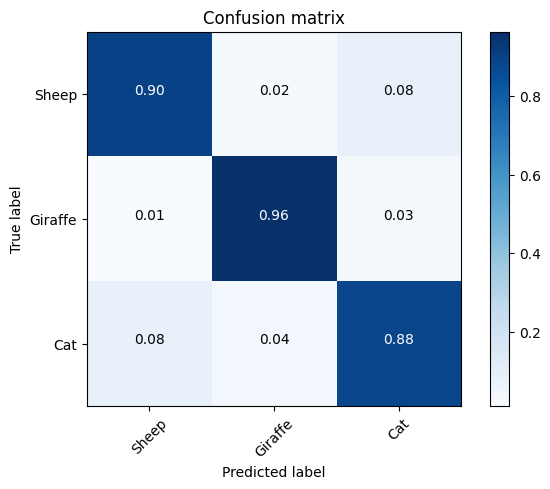

In [13]:
def train_and_return_confusion_matrix(X_tr, Y_tr, X_test, Y_test, levels, activation, alpha, scaler=None):
    # scale data
    X_train_scaled = scaler.fit_transform(X_tr) if scaler else X_tr
    X_test_scaled = scaler.transform(X_test) if scaler else X_test
    # train classifier
    classifier = create_classifier(X_train_scaled, Y_tr, levels=levels, activation=activation, alpha=alpha)
    # return confusion matrix
    print(accuracy(classifier, X_test_scaled, Y_test))
    return metrics.confusion_matrix(Y_test, classifier.predict(X_test_scaled))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# test with best parameters
cm = train_and_return_confusion_matrix(X_train, Y_train, X_test, Y_test, levels = (60,20), alpha=0.0000001, activation='relu', scaler=MinMaxScaler())
plot_confusion_matrix(cm, ["Sheep", "Giraffe", "Cat"], normalize=True)